# Summary:
The lever data, `lever_data`, only holds the raw lever Arduino values from Arduino's `readAnalog()` function, which scales 0-5V (the voltage range going into this pin) to numbers from 0-1023 (so at a resting neutral position, the lever is usually about 550 which anecdotally seems to match Vincent's calculated Voltage of about 2.6V). The Arduino encodes these numbers with values between 0-1023 into 2 bytes of data and sends them over to the computer via USB virtual serial port. The MATLAB program, leverIN_to_matlab.m then listens in and decodes this array of 2 bytes back into the number between 0-1023 and saves it into `lever_data`.

__Additional information on the sampling rate__: It's a more or less consistent sampling rate because the number of data bytes actually being sent through the USB virtual serial port is always exactly 2 bytes. Empirically, it varies, for the first few thousand entries it'll be a little faster ~100us, then for whatever reason it slows down to a more consistent pace of around 150-170us, probably due to hitting/overloading the serial port transfer buffer limit (in the Arduino code, there is no delay, it sends new data as soon as it has read it and reads new data as soon as it's done sending). Since it's so fast, but also empirically quite consistent after the first few thousand entries, I've decided to let go of trying to get it at an exactly even sampling rate since I believe at these several kHz frequencies, the actual animal movements will be approximated closely enough for analysis and comparisons. Plus, sending additional bytes of information (e.g. exact time) through the USB serial port will only slow it down further.

__Notes on running leverIN.ino and leverIN_to_matlab.m__: Will have weird stuff in between the main MATLAB ToneDiscriminationV3_GF.m code running. See ./Data/weird.mat for an example of what I mean. I'm not sure why this is, but behaviorIN.ino gets reset within the code which I believe is why it doesn't have this issue. Therefore, re-upload leverIN.ino and run leverIN_to_matlab.m anew after ToneDiscriminationV3_GF.m code has started running (ToneDiscriminationV3_GF.m code now has a user input break specifically for this as 231030). Pressing ESC to end the ToneDiscriminationV3_GF.m code will also cause it to be weird, but ending normally is okay.

Also, anytime a trial is not currently ongoing--which is when we are in the ITI--so when tStart == LOW or 0V is at the tStart pin (pin 11), `lever_data` will be >2000. First, we will align each trial's MATLAB starting time to each first value of `lever_data` that is not >2000. Dividing the total time between trial start times by the number of entries recorded in `lever_data` between those two points will give an estimate of the sampling frequency and the change in time, `dt`, between any two entries for that trial.

The sensor itself may have some noise above a cutoff frequency, `cutoff_frequency`, of 40 Hz and all relevant attributes of the animal's movement are below 40 Hz. We'll use a sharp 6th order Butterworth filter to filter this out.

Finally, we'll rescale everything from the 0-1023 Arduino values range back to the 0-5V range: $\text{data} \times \frac{5}{1023}$, and save it as `processed_lever_data`.

### imports

In [105]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

# save data
import pickle

### set `folder_name`

In [106]:
# for all .mat files in this folder starting with "ToneDisc_ANChandler_p1_" in their name
folder_name = './Data/AnB1/'

### sort through relevant .mat files found in folder by day ("_d#")

In [107]:
unsorted_mat_files = glob.glob(folder_name+'*.mat')
sorted_mat_files = sorted(unsorted_mat_files, key=lambda x: int(re.search(r'\d+.mat$',x).group()[:-4]))
sorted_mat_files

AttributeError: 'NoneType' object has no attribute 'group'

### load `data` from .mat file and split into `params` and `response`

In [108]:
mat_dict = io.loadmat('./Data/AnB1/ToneDisc_ANB1_30-Oct-2023.mat')

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### Get `respMTX` (trials) from response, `get MTXTrialType` from params

In [109]:
respMTX = response[2]
print("respMTX shape: "+str(respMTX.shape))

MTXTrialType = params[16]
print("MTXTrialType shape: "+str(MTXTrialType.shape))

num_trials = respMTX.shape[0]
print("number of trials: "+str(num_trials))

respMTX shape: (183, 7)
MTXTrialType shape: (1000, 5)
number of trials: 183


preview trials

In [110]:
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(respMTX)

[[1.659345 2.211614 1.000000 ... -2.669569 0.000000 1.000000]
 [20.077773 20.485873 1.000000 ... -2.669569 0.000000 1.000000]
 [46.024086 46.709723 0.000000 ... -2.669569 0.000000 0.000000]
 ...
 [1727.556662 1727.913004 1.000000 ... -2.669569 0.000000 1.000000]
 [1735.185483 1735.831858 1.000000 ... -2.669569 0.000000 1.000000]
 [1740.452002 1741.069882 1.000000 ... -2.669569 0.000000 1.000000]]


### Run the C++ program ./0a_main.cpp to create a binary processed file for `lever_data` from the .mat file

The C++ program does the following:
- opens and reads in the corresponding .mat file
- extracts the `lever_data` variable and puts into a C++ vector<double>
- remove unused empty rows of zeroes (`lever_data` is initialized in ../behavior/leverIN_to_matlab.m to hold up to 2 hours worth of data, but the unused values are just 0s)
- extracts each individual trial+subsequent ITI of the `lever_data` and re-lowers the ITI values back down to 0-1023 instead of 2000-2023
- save each trial+ITI chunk of `lever_data` to its own .bin file

Here's an equivalent python program of what we're about to run in C++:
```
[need to write equivalent python program]
```

In [112]:
!g++ -I/opt/homebrew/opt/libmatio/include/ -L/opt/homebrew/Cellar/libmatio/1.5.24/lib/ -o 0a_main 0a_main.cpp -lmatio
!./0a_main

lever_data from .mat size: 72000000,72000000
lever_data from .mat rank: 2
lever_data vector size: 72000000
lever_data vector with unused rows taken out size: 10274480
vector saved to .bin file ./Data/AnB1/B1_20231030_lever_data.bin
finished a trialITI: 91195 trialITI length: 75735 samples = ~15s
vector saved to .bin file ./Data/AnB1/B1_20231030_trial0.bin
finished a trialITI: 243822 trialITI length: 152627 samples = ~30s
vector saved to .bin file ./Data/AnB1/B1_20231030_trial1.bin
finished a trialITI: 303292 trialITI length: 59470 samples = ~11s
vector saved to .bin file ./Data/AnB1/B1_20231030_trial2.bin
finished a trialITI: 359150 trialITI length: 55858 samples = ~11s
vector saved to .bin file ./Data/AnB1/B1_20231030_trial3.bin
finished a trialITI: 517281 trialITI length: 158131 samples = ~31s
vector saved to .bin file ./Data/AnB1/B1_20231030_trial4.bin
finished a trialITI: 577338 trialITI length: 60057 samples = ~12s
vector saved to .bin file ./Data/AnB1/B1_20231030_trial5.bin
finis

### Look at sampling rates for the `lever_data`
For each trial, get the MATLAB time duration from `respMTX` (index 0 is the trial start time) and get `lever_data` from the C++ program ./0a_main.cpp created binary .bin file. Divide the number of samples by the MATLAB time duration to get the estimated frequency and check that it's consistent.

A lever movement can be less than 100 ms

In [113]:
dts = []
trial_frequencies = []
for i in range(0, num_trials-1):
    print("Trial ",i)
    # from the .mat file's respMTX, index 0 is the trial start time
    trial_start_time = respMTX[i][0]
    next_trial_start_time = respMTX[i+1][0]
    print("Duration in MATLAB seconds from respMTX: ", next_trial_start_time - trial_start_time)

    # Read the binary file created by the C++ program which is saved as double
    trial_lever_data = np.fromfile("./Data/AnB1/B1_20231030_trial"+str(i)+".bin", dtype=np.double)
    print("Number of lever_data samples: ", trial_lever_data.shape[0])

    frequency = trial_lever_data.shape[0] / (next_trial_start_time - trial_start_time)
    print("Estimated freq: ", frequency)
    trial_frequencies.append(frequency)
    intersample_duration = 1 / frequency

    # for Dr. Sur
    for i in range(0, trial_lever_data.shape[0]):
        dts.append(intersample_duration)

#... last trial got cut off I'm pretty sure, so assume trial_frequency didn't change much between second to last to last trial
trial_frequencies.append(frequency)

# use numpy to same trial_frequencies into a .bin (not pickle because just in case need to reopen in C++)
trial_frequencies_np = np.array(trial_frequencies)
trial_frequencies_np.astype('double').tofile("./Data/AnB1/B1_20231030_trial_frequencies.bin")

Trial  0
Duration in MATLAB seconds from respMTX:  18.4184281
Number of lever_data samples:  75735
Estimated freq:  4111.914414672553
Trial  1
Duration in MATLAB seconds from respMTX:  25.946313
Number of lever_data samples:  152627
Estimated freq:  5882.415740533154
Trial  2
Duration in MATLAB seconds from respMTX:  10.109772299999996
Number of lever_data samples:  59470
Estimated freq:  5882.427243193205
Trial  3
Duration in MATLAB seconds from respMTX:  9.495943099999998
Number of lever_data samples:  55858
Estimated freq:  5882.301464085227
Trial  4
Duration in MATLAB seconds from respMTX:  26.882401400000006
Number of lever_data samples:  158131
Estimated freq:  5882.324188493069
Trial  5
Duration in MATLAB seconds from respMTX:  10.2096971
Number of lever_data samples:  60057
Estimated freq:  5882.348850486465
Trial  6
Duration in MATLAB seconds from respMTX:  9.875265499999998
Number of lever_data samples:  58089
Estimated freq:  5882.272228528946
Trial  7
Duration in MATLAB sec

make a histogram for Dr. Sur

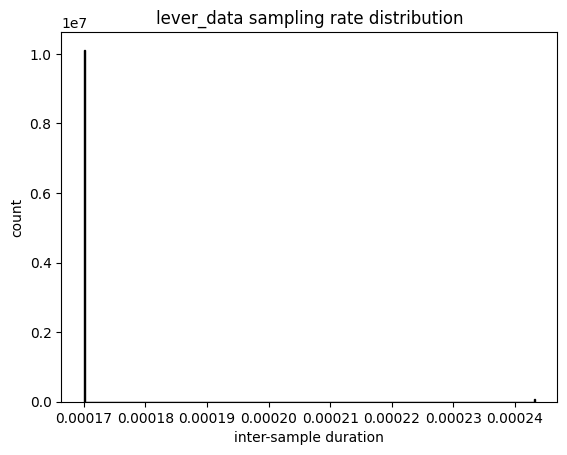

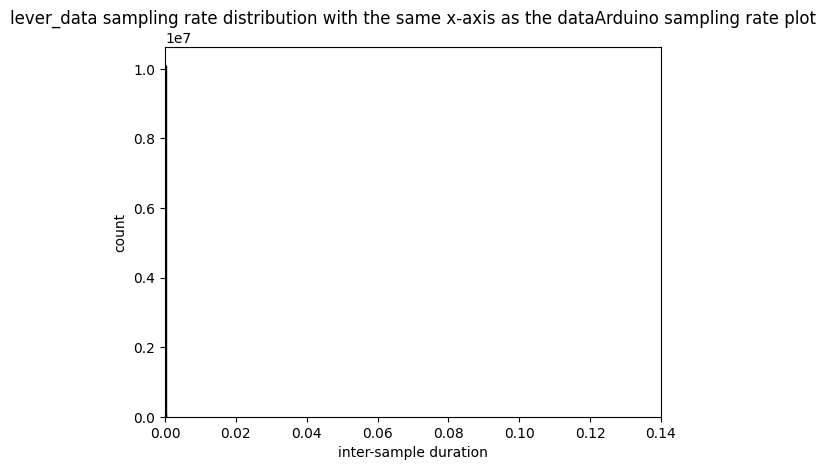

mean:  5863.553632027255  Hz
std:  159109.91481892517  Hz
min:  4111.914414672553  Hz
max:  5882.776329143213  Hz
90th slowest percentile 5882.195786268558
99th slowest percentile 5881.783760278223
99.9th slowest percentile 4111.914414672553


In [67]:
plt.hist(dts, bins=500, edgecolor='black')
plt.xlabel('inter-sample duration')
plt.ylabel('count')
#plt.xlim([0, 0.14])
plt.title("lever_data sampling rate distribution")
plt.show()

plt.hist(dts, bins=500, edgecolor='black')
plt.xlabel('inter-sample duration')
plt.ylabel('count')
plt.xlim([0, 0.14])
plt.title("lever_data sampling rate distribution with the same x-axis as the dataArduino sampling rate plot")
plt.show()

# print out mean and std of sampling rate
print("mean: ", 1 / (sum(dts) / len(dts)), " Hz")
print("std of intersample duration: ", np.std(dts), " s")
print("min: ", 1 / max(dts), " Hz")
print("max: ", 1 / min(dts), " Hz")
print("90th slowest percentile", 1 / np.percentile(dts, 90))
print("99th slowest percentile", 1 / np.percentile(dts, 99))
print("99.9th slowest percentile", 1 / np.percentile(dts, 99.9))

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

In [114]:
for i in range(0, num_trials):
    # Read the binary file created by the C++ program which is saved as double
    trial_frequencies = np.fromfile("./Data/AnB1/B1_20231030_trial_frequencies.bin", dtype=np.double)

    # Butterworth filter parameters:
    fs = trial_frequencies[i]
    fc = 40  # Cut-off frequency of the filter
    wn = fc / (fs / 2) # Normalize the frequency
    butterworth_order = 6

    # Read the binary file created by the C++ program which is saved as double
    trial_lever_data = np.fromfile("./Data/AnB1/B1_20231030_trial"+str(i)+".bin", dtype=np.double)

    # Run Butterworth Filter
    b, a = signal.butter(butterworth_order, wn, 'lowpass')
    filtered_lever_data = signal.filtfilt(b, a, trial_lever_data)

    # use numpy to same trial_frequencies into a .bin (not pickle because just in case need to reopen in C++)
    filtered_lever_data.astype('double').tofile("./Data/AnB1/B1_20231030_filtered_trial"+str(i)+".bin")

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [115]:
for i in range(0, num_trials):

    # Read the binary file created by the C++ program which is saved as double
    filtered_lever_data = np.fromfile("./Data/AnB1/B1_20231030_filtered_trial"+str(i)+".bin", dtype=np.double)

    # Rescale to 0-5V from 0-1023 analogRead values
    processed_lever_data = filtered_lever_data * 5/1023

    # use numpy to same trial_frequencies into a .bin (not pickle because just in case need to reopen in C++)
    processed_lever_data.astype('double').tofile("./Data/AnB1/B1_20231030_processed_trial"+str(i)+".bin")


### Check the FFT power spectrum for a trial

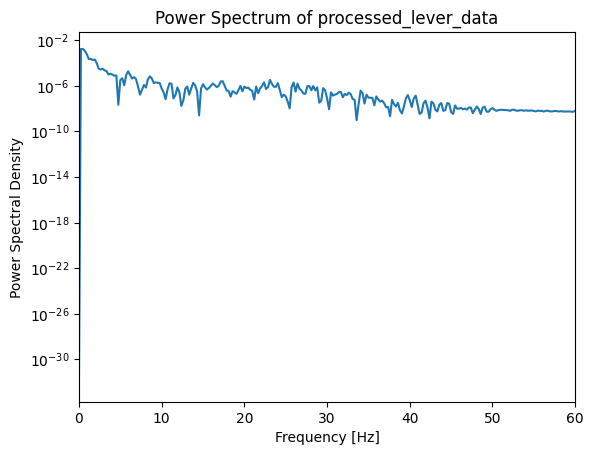

In [120]:
i = -1

# Read the binary file created by the C++ program which is saved as double
trial_frequencies = np.fromfile("./Data/AnB1/B1_20231030_trial_frequencies.bin", dtype=np.double)

fs = trial_frequencies[i]
freq, spectra = signal.periodogram(processed_lever_data, fs=fs)

fig, ax = plt.subplots()
ax.semilogy(freq, spectra)
ax.set_title('Power Spectrum of '+'processed_lever_data')
ax.set_ylabel('Power Spectral Density')
ax.set_xlabel('Frequency [Hz]')
plt.xlim([0, 60])
plt.show()